In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft2, ifft2
from scipy.optimize import minimize
from sklearn import datasets

Consider retrieving $x \in \mathbb{C}^n$ from measurements

$$y = \mathcal{A}(x) + \epsilon,$$

by solving

$$\min_z J(z), \quad J(z)  = \|\mathcal{A}\circ \mathcal{G} (z) - y\|_2^2 + \lambda^2\|z\|_2^2,$$

where $\mathcal{G}$ is a generative model.

The gradient of $J$ is given by

$$\nabla J(z) = \left(\mathcal{G}'(z)\right)^*\left(\mathcal{A}'(x)\right)^*\left(\mathcal{A}\circ \mathcal{G} (z) - y\right),$$

with $x = \mathcal{G}(z)$ and $\mathcal{G}'(z)$ the Jacobian of $\mathcal{G}$ and $\mathcal{A}'(x)$ the Jacobian of $\mathcal{A}$. 

We typically consider 

$$\mathcal{A}(x) = |Ax|^2,$$

for some given matrix $A \in \mathbb{C}^{m\times n}$. In that case we have

$$\mathcal{A}'(x) = 2\text{diag}(Ax)\overline{A}.$$

We take $A$ to be a masked Fourier transform, in which case it is given by

$$A = \left(\begin{matrix} FM_1 \\ FM_2 \\ \vdots \\ FM_m\end{matrix}\right),$$

with $F \in \mathbb{C}^{n\times n}$ the 2D Fourier transform and $M_i \in \mathbb{C}^{n\times n}$ a diagonal matrix containing a mask.

A simple generative model can be obtained as

$$\mathcal{G}(z) = \mu + Sz, $$

with $\mu$ the mean of the training samples, and $S$ a Cholesky factorisation of the sample covariance matrix (i.e., $\Sigma = SS^*$.)

We can also let $\mathcal{G}(z) = z$ and $\mathcal{G}(z) = \mu + Sz_1 + z_2$.

In [2]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [3]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv)
    
    return A

In [4]:
# load data set of 3's
(digits, cls) = datasets.load_digits(return_X_y=True)
X = np.ones((183, 64)) + 1j*digits[np.where(cls==3)[0],:]/16

n = X.shape[1]
nx = int(np.sqrt(n))

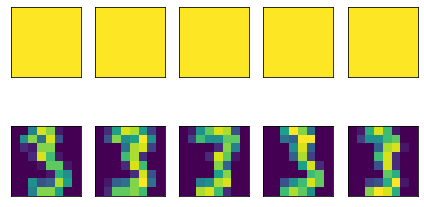

In [5]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = X[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_data.png',dpi=300)

In [6]:
# get prior
mu    = np.mean(X,axis=0)
Sigma = np.conj((X-mu).T)@(X-mu)/X.shape[0]
s, U = np.linalg.eigh(Sigma + 1e-6*np.eye(n))

k = 30
B = U[:,-k:]@np.diag(np.sqrt(s[-k:]))

C = np.concatenate((np.real(B), np.eye(n)), axis=1)

# define generative models
G = Op(fun = lambda z : mu + B@z, jac = lambda z : LinearOperator((n, k), matvec = lambda z : B@z, rmatvec = lambda z : np.conj(B.T)@z), shape=(n,k))
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))
H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

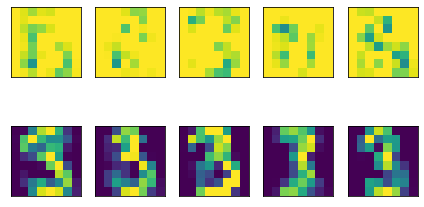

In [7]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_generative.png',dpi=300)

In [8]:
# define forward operator
mx = 100
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

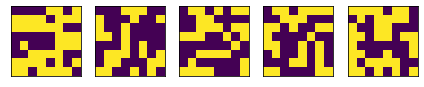

In [9]:
# plot some of the masks
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[i].imshow(M[:,:,i],clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_masks.png',dpi=300)

1.0023377970085202e-06


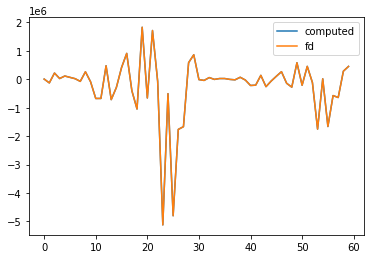

In [10]:
# gradient test
h = 1e-8

k  = G.shape[1]
zt = np.random.randn(2*k)
yt = np.random.randn(A.shape[0])

obj = lambda z : objective(z, yt, A, G)

val, grad = obj(zt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)

print(np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

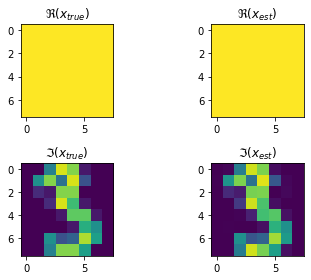

In [11]:
# reconstruct without generative model and plot result
xtrue = X[0]
error, xhat, yobs, result = reconstruct(xtrue, A, G)

plot_result(xtrue, xhat)

In [12]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k))

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

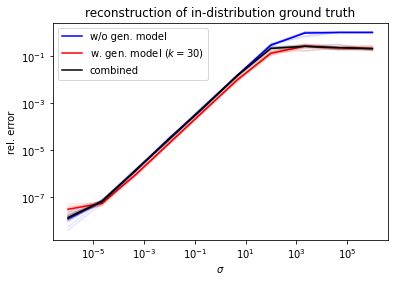

In [13]:
fig, ax = plt.subplots(1)

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of in-distribution ground truth')
ax.legend()

plt.savefig('example1_recon1.png', dpi=300)

In [14]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = X[np.random.randint(0,X.shape[0])]
        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

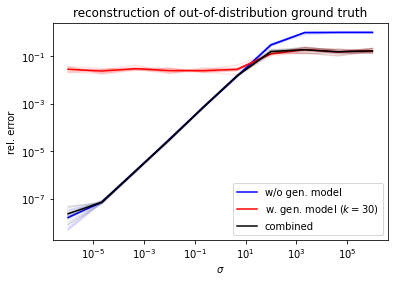

In [15]:
fig, ax = plt.subplots(1)

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of out-of-distribution ground truth')

ax.legend()
plt.savefig('example1_recon2.png', dpi=300)